In [1]:
from datetime import datetime
import pandas as pd
pd.set_option('display.max_columns', None)

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

# Fill in Parameters here

In [2]:
tuned_parameters = [{'n_estimators': list(range(15,25,1)),
                     "max_depth":list(range(5,15,1)),
                     "criterion":["gini"],
                    'bootstrap':[False]}]
scoring_parameter = "accuracy"
city1 = "Osaka"
city2 = "Tokyo"

# Data Processing

In [3]:
### Extract 
data_df_extract = pd.read_csv("data_transformed.csv")
data_df_original = data_df_extract.copy()
data_df_original.head()

,time,latitude,longitude,depth,mag,Nearest City,Distance,label
0,2022-04-18,36.9462,140.3737,94.06,5.3,Tokyo,152.519581,True
1,2022-04-18,29.7594,142.1689,10.00,4.9,>200 KM of Nearest City,698.847508,True
2,2022-04-17,37.7504,141.7200,55.40,4.5,Sendai,94.259210,False
3,2022-04-17,31.1878,142.4014,10.00,4.5,>200 KM of Nearest City,560.090362,False
4,2022-04-17,37.0863,142.1903,30.46,4.4,Sendai,175.485563,False


# Random Forest for Earthquakes close to City 1

In [4]:
data_df = data_df_original.loc[data_df_original["Nearest City"]==city1]
data_df.reset_index(drop=True, inplace=True)
data_df.head(3)

,time,latitude,longitude,depth,mag,Nearest City,Distance,label
0,2022-03-31,35.0658,135.5220,26.6,4.4,Osaka,41.425932,False
1,2022-03-11,34.8133,135.2084,10.0,4.3,Osaka,29.938712,False
2,2022-01-30,34.7475,135.9508,10.0,3.9,Osaka,41.458675,False


In [5]:
data_df['mag'].value_counts()

4.5    35
4.7    34
4.6    31
4.4    26
4.2    24
4.1    22
4.8    19
4.3    16
3.9    15
4.0    14
3.6    13
3.8    13
4.9    13
5.0     9
5.1     9
3.7     7
5.5     7
3.4     5
5.7     4
5.2     4
6.3     4
5.8     4
3.5     4
2.7     3
3.2     3
3.3     3
2.9     3
3.1     3
6.7     2
5.3     2
5.4     2
7.0     2
5.9     2
2.5     2
6.1     1
8.1     1
6.5     1
6.4     1
3.0     1
6.2     1
6.6     1
5.6     1
7.2     1
8.3     1
6.9     1
Name: mag, dtype: int64

In [6]:
data_df = data_df.drop(columns = ['latitude', 'longitude','time',"Nearest City","mag","Distance"] )
#data_df = data_df.drop(columns = ['latitude', 'longitude','time', "mag","Distance"] )

In [7]:
data_df['label'].value_counts()

False    243
True     127
Name: label, dtype: int64

In [8]:
# Extract Training and Validation Dataset
X = data_df.drop(["label"], axis=1)
y = data_df["label"]

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3,random_state=100)
print(len(X_train))
print(len(X_validation))

259
111


In [9]:
clf_model_randomforest = GridSearchCV(RandomForestClassifier(random_state=100),
                                      tuned_parameters,
                                      cv=5,
                                      scoring=scoring_parameter,
                                      verbose=1)
clf_model_randomforest.fit(X_train.values, y_train.values)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             param_grid=[{'bootstrap': [False], 'criterion': ['gini'],
                          'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                          'n_estimators': [15, 16, 17, 18, 19, 20, 21, 22, 23,
                                           24]}],
             scoring='accuracy', verbose=1)

In [10]:
clf_model_randomforest.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=12, n_estimators=15,
                       random_state=100)

In [11]:
clf_model_randomforest.best_params_

{'bootstrap': False, 'criterion': 'gini', 'max_depth': 12, 'n_estimators': 15}

In [12]:
# Validate RandomForest with Validation dataset
predict_y_validation = clf_model_randomforest.predict(X_validation.values)
accuracy_score_results = accuracy_score(y_validation.values, predict_y_validation)
print("validation accuracy:", accuracy_score_results)

validation accuracy: 0.6576576576576577


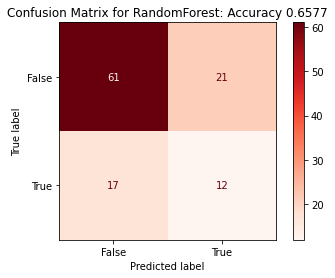

True Positive = 61
False Positive = 17
False Negative = 21
True Negative = 12
Recall = 74.0
Precision = 78.0
              precision    recall  f1-score   support

       False       0.78      0.74      0.76        82
        True       0.36      0.41      0.39        29

    accuracy                           0.66       111
   macro avg       0.57      0.58      0.57       111
weighted avg       0.67      0.66      0.66       111



In [13]:
#########################################
### Display Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_validation.values, predict_y_validation, cmap='Reds')
plt.title("""Confusion Matrix for RandomForest: Accuracy {:.4}""".format(accuracy_score_results),color='black')
plt.show()

confusion_matrix_metric = confusion_matrix(y_validation.values, predict_y_validation)
TP = confusion_matrix_metric[0][0]
FP = confusion_matrix_metric[1][0]
FN = confusion_matrix_metric[0][1]
TN = confusion_matrix_metric[1][1]

print('True Positive = {}'.format(TP))
print('False Positive = {}'.format(FP))
print('False Negative = {}'.format(FN))
print('True Negative = {}'.format(TN))
print('Recall = {}'.format(100*round(TP/(TP+FN),2)))
print('Precision = {}'.format(100*round(TP/(TP+FP),2)))
print(classification_report(y_validation.values, predict_y_validation))

# Random Forest for Earthquakes close to City 2

In [14]:
data_df = data_df_original.loc[data_df_original["Nearest City"]==city2]
data_df.reset_index(drop=True, inplace=True)
data_df.head(3)

,time,latitude,longitude,depth,mag,Nearest City,Distance,label
0,2022-04-18,36.9462,140.3737,94.06,5.3,Tokyo,152.519581,True
1,2022-04-12,34.5523,140.4059,53.99,4.5,Tokyo,142.153831,False
2,2022-04-10,36.1869,141.5319,35.00,5.0,Tokyo,174.661026,True


In [15]:
data_df['mag'].value_counts()

4.5    559
4.6    518
4.7    421
4.8    330
4.4    284
4.3    249
4.9    248
4.2    217
4.1    188
5.0    171
4.0    137
5.1    124
3.9    110
5.2     98
5.3     74
3.8     69
3.7     54
5.4     52
5.5     46
5.6     46
5.7     41
3.6     39
5.8     37
5.9     25
3.5     20
6.0     17
3.4     16
6.1     14
6.2     13
3.3     13
6.3     10
3.2      9
3.1      9
6.5      6
6.7      4
6.4      3
3.0      3
6.6      3
6.9      3
7.7      2
2.6      2
2.8      2
6.8      2
7.2      1
2.7      1
7.5      1
7.1      1
8.1      1
7.8      1
7.0      1
2.9      1
7.9      1
Name: mag, dtype: int64

In [16]:
data_df = data_df.drop(columns = ['latitude', 'longitude','time',"Nearest City","mag","Distance"] )
#data_df = data_df.drop(columns = ['latitude', 'longitude','time', "mag","Distance"] )

In [17]:
data_df['label'].value_counts()

False    2500
True     1797
Name: label, dtype: int64

In [18]:
# Extract Training and Validation Dataset
X = data_df.drop(["label"], axis=1)
y = data_df["label"]

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3,random_state=100)
print(len(X_train))
print(len(X_validation))

3007
1290


In [19]:
clf_model_randomforest = GridSearchCV(RandomForestClassifier(random_state=100),
                                      tuned_parameters,
                                      cv=5,
                                      scoring=scoring_parameter,
                                      verbose=1)
clf_model_randomforest.fit(X_train.values, y_train.values)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             param_grid=[{'bootstrap': [False], 'criterion': ['gini'],
                          'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                          'n_estimators': [15, 16, 17, 18, 19, 20, 21, 22, 23,
                                           24]}],
             scoring='accuracy', verbose=1)

In [20]:
clf_model_randomforest.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=7, n_estimators=15,
                       random_state=100)

In [21]:
clf_model_randomforest.best_params_

{'bootstrap': False, 'criterion': 'gini', 'max_depth': 7, 'n_estimators': 15}

In [22]:
# Validate RandomForest with Validation dataset
predict_y_validation = clf_model_randomforest.predict(X_validation.values)
accuracy_score_results = accuracy_score(y_validation.values, predict_y_validation)
print("validation accuracy:", accuracy_score_results)

validation accuracy: 0.6139534883720931


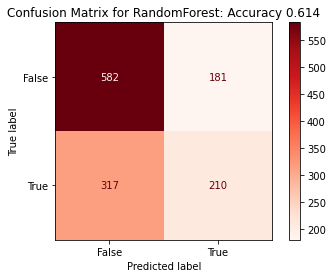

True Positive = 582
False Positive = 317
False Negative = 181
True Negative = 210
Recall = 76.0
Precision = 65.0
              precision    recall  f1-score   support

       False       0.65      0.76      0.70       763
        True       0.54      0.40      0.46       527

    accuracy                           0.61      1290
   macro avg       0.59      0.58      0.58      1290
weighted avg       0.60      0.61      0.60      1290



In [23]:
#########################################
### Display Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_validation.values, predict_y_validation, cmap='Reds')
plt.title("""Confusion Matrix for RandomForest: Accuracy {:.4}""".format(accuracy_score_results),color='black')
plt.show()

confusion_matrix_metric = confusion_matrix(y_validation.values, predict_y_validation)
TP = confusion_matrix_metric[0][0]
FP = confusion_matrix_metric[1][0]
FN = confusion_matrix_metric[0][1]
TN = confusion_matrix_metric[1][1]

print('True Positive = {}'.format(TP))
print('False Positive = {}'.format(FP))
print('False Negative = {}'.format(FN))
print('True Negative = {}'.format(TN))
print('Recall = {}'.format(100*round(TP/(TP+FN),2)))
print('Precision = {}'.format(100*round(TP/(TP+FP),2)))
print(classification_report(y_validation.values, predict_y_validation))

### 